# Practical 4: Recurrent Neural Networks

For most NLP problems the input representations consist of sequences of words (sentences, paragrphs, etc). The words in a sequnce have a temporal relationship, or in other words, the *order* in which they appear changes the meaning of the sequence. In the previous practical we looked at several text classification methods which were unable to model this sequential relationship. Either because the algorithm processes all input features at once, or because the temporal relationship is lost through the chosen representation (BOW/TF-IDF), or both.

In contrast, RNN process each feature of an input exaple in turn, at each timestep. So each word of an input sequnce is processed and used to update an internal *hidden state*, or memory, of the network. Thus RNN are able to capture temporal relationships between each feature of an input example. For this reason RNN are frequently used form many NLP tasks, such as classification and language modelling.

In the first part of this practical we will apply an RNN (LSTM) to the task of sentiment classifcation on the IMDB dataset. We will use word embedding representations for each word in the input sequence.

In the second part of this practical we will explore various different configurations for RNN models, including bi-directional and stacked (or deep) RNNs. We will also use Comet ML to record results and compare different models and hyperparameter configurations.

The objectives of this practical are:
1. Understand the key concepts for applying RNN to NLP tasks, specifically input representations and shape

2. Consider different RNN configurations and output modes, including returning sequences, or only the last hidden state, bi-directional and stacked RNN

3. Compare and contrast different hyperparameters and models, making use of ML platforms, like Comet ML, to record and present results

# 1 LSTM for Sentiment Classification

## 1.0 Import libraries

In [ ]:
import os
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.downloader as gen
import tensorflow as tf
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
%matplotlib inline

# Set the directory to the data folder
data_dir = os.path.join('..', 'data', 'imdb')

# Spacy needs to install the language model also
# If you recieve an error, uncomment the following line and re-run the cell
# !python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

## 1.1 Load and pre-process data

1. First load the full IMDB dataset and our smaller reviews set.

2. Then we need to convert the 'positive' and 'negative' class labels to numerical values, 1 for positive and 0 for negative. Using the pandas `get_dummies` function creates two binary valued columns and then the `drop_first` parameter collapses these into a single column.

3. The next cell plots the distribution of reveiew lengths in terms of number of tokens. This is important for RNN models because each token of an input review will be processed in turn, and so each input example will be a different length. Padding each review to the length of the longest in the data will increase processing time and may impact performance, so the distribution allows us to choose a suitable `max_seq_len` for the model to process. From the graph it looks like most reviews are less than 200 in length, so 100 to 200 should be a suitable `max_seq_len`.

In [ ]:
# Load the imdb dataset
imdb_data = pd.read_csv(os.path.join(data_dir, 'imdb_dataset.csv'))

# Load your imdb reviews
imdb_reviews = pd.read_csv(os.path.join(data_dir, 'imdb_reviews.csv'), index_col=0)
# Just keep the review text and the sentiment columns
imdb_reviews = imdb_reviews[['review', 'sentiment']]

# Convert the sentiment to a binary value
imdb_data['sentiment'] = pd.get_dummies(imdb_data['sentiment'], drop_first=True)
imdb_reviews['sentiment'] = pd.get_dummies(imdb_reviews['sentiment'], drop_first=True)

imdb_data.head()

In [ ]:
# Tokenise the reviews
tokenised_data = imdb_data['review'].apply(lambda x: [token.text for token in nlp.tokenizer(x)])

# Plot the distribution of review lengths
seq_lengths = [len(review) for review in tokenised_data]
sns.displot(seq_lengths, kind='hist')
plt.show()

### Load the vocabulary

You should have also created a vocabulary from the larger IMDB dataset, so lets load that and set the vocabulary size accordingly. We will also add some special padding and unknown tokens for use later.

In [ ]:
# Load the vocabulary file and store each word in a list
with open(os.path.join(data_dir, 'imdb_vocab.txt'), 'r') as file:
    imdb_vocab = file.read().splitlines() 
    
# Set the vocab size
vocab_size = 2000

# Add the padding and unknown tokens to the vocabulary
imdb_vocab.insert(0, '')
imdb_vocab.insert(1, '[UNK]')
imdb_vocab = imdb_vocab[:vocab_size]

# Print the vocabulary
print("Vocabulary size: " + str(vocab_size))
for i, word in enumerate(imdb_vocab[:50]):
    print(f'({str(i)}, {word})', end=' ')

### Process and vectorise the text

We will be using embedding representations as input to the RNN model, so each word in an input review needs to be mapped to its embedding vector. To do this we must first map each word to an integer according to its index within the vocabulary and then use that as a 'lookup' for the corresponding embedding. The result will be a 2D matrix/tensor of shape (`max_seq_len`, `embedding_dim`) for each input example. However, performing these steps manually beforhand results in a very large input tensor! So we will take advantage of the `TextVectorisation` layer and `Embedding` layer in Keras.

1. We will split the data as normal, using the full IMDB data as training and validation and our reviews as a test set.

2. Set up the text vectorisation layer with our vocabulary and specified `max_seq_len`. This layer takes a string input, tokenises each word, maps to integers and then outputs a sequence of the specified length.

In [ ]:
# Set the maximum sequence legth
max_seq_len = 200

# Get the reviews
X = imdb_data['review'].values
print('Shape of X:', X.shape)
print(X[:2])

# Get the class labels
y = imdb_data['sentiment'].values
print('Shape of y:', y.shape)
print(y[:2])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Get the test data
X_test = imdb_reviews['review'].values
y_test = imdb_reviews['sentiment'].values

# Create the text vectoriser
vectorise_layer = layers.experimental.preprocessing.TextVectorization(
 max_tokens=vocab_size,
 standardize=None,
 split='whitespace',
 output_mode='int',
 output_sequence_length=max_seq_len,
 pad_to_max_tokens=False,
 vocabulary=imdb_vocab
 )

# Adapt the vectoriser to the training data
vectorise_layer.adapt(X_train)

# Vocabulary size and content should be the same as above
print("Vectoriser vocabulary size: " + str(len(vectorise_layer.get_vocabulary())))
print(vectorise_layer.get_vocabulary()[:50])

### Create an embedding matrix

We need to create an embedding matrix of shape (`vocab_size`, `embedding_dim`). This will be the 'lookup' table for each word in an input sequence to be mapped to its embedding. We will use pre-trained [GloVe](https://nlp.stanford.edu/projects/glove/) embeddings as these should already contain information about the word relations from the millions of words they were trained on.

1. Create a numpy embedding matrix by looping over the vocabulary and assigning each word an embedding. If the word is not present in the GloVe vectors we will generate a random embedding.

2. Then create an embedding layer using the embedding matrix as the lookup. This layer takes a `max_seq_len` sequence of integers as input and maps each word to an embedding to produce a tensor of shape (`max_seq_len`, `embedding_dim`).

In [ ]:
# Set the embedding dimension
embedding_dim = 300

# Load the word embeddings
glove_vectors = gen.load("glove-wiki-gigaword-300")

# Generate the embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for i, word in enumerate(imdb_vocab):
    if word in glove_vectors:
        embedding_matrix[i] = glove_vectors[word]
    else:
        embedding_matrix[i] = np.random.uniform(low=-1.0, high=1.0, size=embedding_dim)

print('Shape of embeddings:', embedding_matrix.shape)
print(embedding_matrix[:5])

# Create the embedding layer
embedding_layer = layers.Embedding(
 input_dim=vocab_size,
 output_dim=embedding_dim,
 input_length=max_seq_len,
 embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
 trainable=False)

## 1.2 Build the RNN model

The cell below creates a Keras functional model:
- The input layer takes a batch of single strings

- Vectorisation layer tokenises and maps each word to integers.

- Embedding layer maps each sequence of words to embeddings

- RNN processes each word in the sequence in turn. Here, because `return_sequences=False` we are taking the last hidden state as the encoded sequence representation.

- Finally several feed forward layers perform classification.

Study the model summary and make sure you are happy with the different operations and resulting tensor shapes as data passes through the model.

In [ ]:
# Input layer takes in a string
inputs = tf.keras.Input(shape=(1,), dtype=tf.string)

# Vectorise the inputs
vectorised_inputs = vectorise_layer(inputs)

# Embed the inputs
embedded_inputs = embedding_layer(vectorised_inputs)

# Recurrent layer
x = layers.LSTM(128, return_sequences=False)(embedded_inputs)

# Classification layers
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# Compile the model
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="LSTM")
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

### Train and evaluate the model

In [ ]:
# Fit the model
results = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val))
print("Validation Accuracy:", round(results.history["val_accuracy"][-1], 3))

# Predict class labels for test set
predictions = model.predict(X_test)
predictions = [0 if x < 0.5 else 1 for x in predictions] # Convert probabilities to binary
print('Test Accuracy:', accuracy_score(y_test, predictions))

# Print confusion matrix
conf_matrix = ConfusionMatrixDisplay.from_predictions(y_test, predictions, display_labels=['negative', 'positive',], colorbar=False)
plt.show()

# 2 Experimenting with RNN

## 2.0 Import libraries

1. [Comet ML](https://www.comet.com/) - is an experiment and model tracking API which allows easy logging of model hyperparameters and experiment metrics.

In [1]:
import comet_ml
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.downloader as gen
import tensorflow as tf
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
%matplotlib inline

# Set the directory to the data folder
data_dir = os.path.join('..', 'data', 'imdb')

## 2.1 Load and pre-process data

In [2]:
# Load the imdb dataset
imdb_data = pd.read_csv(os.path.join(data_dir, 'imdb_dataset.csv'))

# Load your imdb reviews
imdb_reviews = pd.read_csv(os.path.join(data_dir, 'imdb_reviews.csv'), index_col=0)
# Just keep the review text and the sentiment columns
imdb_reviews = imdb_reviews[['review', 'sentiment']]

# Convert the sentiment to a binary value
imdb_data['sentiment'] = pd.get_dummies(imdb_data['sentiment'], drop_first=True)
imdb_reviews['sentiment'] = pd.get_dummies(imdb_reviews['sentiment'], drop_first=True)

imdb_data.head()

,review,sentiment
0,reviewers mentioned watching 1 oz episode hook...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake thinks zombie...,0
4,petter mattei s love time money visually stunn...,1


### Load the vocabulary

In [3]:
# Load the vocabulary file and store each word in a list
with open(os.path.join(data_dir, 'imdb_vocab.txt'), 'r') as file:
    imdb_vocab = file.read().splitlines() 
    
# Set the vocab size
vocab_size = 2000

# Add the padding and unknown tokens to the vocabulary
imdb_vocab.insert(0, '')
imdb_vocab.insert(1, '[UNK]')
imdb_vocab = imdb_vocab[:vocab_size]

# Print the vocabulary
print("Vocabulary size: " + str(vocab_size))
for i, word in enumerate(imdb_vocab[:50]):
    print(f'({str(i)}, {word})', end=' ')

Vocabulary size: 2000
(0, ) (1, [UNK]) (2, movie) (3, film) (4, s) (5, like) (6, good) (7, time) (8, story) (9, bad) (10, people) (11, great) (12, way) (13, movies) (14, characters) (15, think) (16, watch) (17, character) (18, films) (19, seen) (20, love) (21, plot) (22, life) (23, acting) (24, best) (25, know) (26, little) (27, man) (28, better) (29, end) (30, scene) (31, scenes) (32, real) (33, thing) (34, watching) (35, actors) (36, director) (37, old) (38, years) (39, funny) (40, going) (41, work) (42, 10) (43, actually) (44, makes) (45, look) (46, find) (47, new) (48, lot) (49, want) 

### Process and vectorise the text

In [4]:
# Set the maximum sequence legth
max_seq_len = 200

# Get the reviews
X = imdb_data['review'].values
print('Shape of X:', X.shape)
print(X[:2])

# Get the class labels
y = imdb_data['sentiment'].values
print('Shape of y:', y.shape)
print(y[:2])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Get the test data
X_test = imdb_reviews['review'].values
y_test = imdb_reviews['sentiment'].values

Shape of X: (50000,)
['reviewers mentioned watching 1 oz episode hooked right exactly happened thing struck oz brutality unflinching scenes violence set right word trust faint hearted timid pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda city home aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements far away main appeal fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess episode saw struck nasty surreal ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order away mannered middle class inmates turned prison bitches lack street skills prison experience watching oz comfortable uncomfortable viewing t

### Create an embedding matrix

In [5]:
# Set the embedding dimension
embedding_dim = 300

# Load the word embeddings
glove_vectors = gen.load("glove-wiki-gigaword-300")

# Generate the embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for i, word in enumerate(imdb_vocab):
    if word in glove_vectors:
        embedding_matrix[i] = glove_vectors[word]
    else:
        embedding_matrix[i] = np.random.uniform(low=-1.0, high=1.0, size=embedding_dim)

print('Shape of embeddings:', embedding_matrix.shape)
print(embedding_matrix[:5])

Shape of embeddings: (2000, 300)
[[-0.14515546 -0.39247585 -0.25915112 ...  0.4540832  -0.04217864
   0.66845111]
 [-0.8630558  -0.4488386   0.73237626 ...  0.46465078  0.79680394
   0.45015108]
 [-0.138      -0.12203     0.0054643  ...  0.19934     0.057473
  -0.023767  ]
 [-0.030351   -0.17344999 -0.097576   ...  0.26174     0.083567
  -0.19064   ]
 [ 0.31000999  0.046907   -0.31283    ... -0.74206001 -0.41123
   0.73799002]]


## 2.2 Set up the Comet experiment and build the model

Here we will train a similar LSTM model but we will use Comet ML to log the training metrics and model hyperparameters. This will allow us to compare the impact of different models and different hyperparamters on the sentiment classification task. Comet allows you to track models, experiments and also produce graphs for comparison.

1. You will need a Comet ML account and  optionally to have created a project. Once you have an account you will need your API key. A guide can be found [here](https://www.comet.com/docs/v2/guides/getting-started/quickstart/).

2. The first two lines create a comet experiment object that will be used to track the training and log metrics/parameters. You need the API key, to (optionally) provide a project name and set the workspace to your username. Then we can also provide a name for this experiment.

3. Next some experiment and model hyperparameters are set within a dictionary. These can be any relevant values but for now we have one pre-processing parameter (`max_seq_len`), several model hyperparameters and some training parameters (`batch_size` and `epochs`).

4. Finally, build the model as before, except use the parameters defined within the dictionary.

In [9]:
# Create the comet ml experiment
experiment = comet_ml.Experiment(workspace="nathanduran", log_env_gpu=False)
experiment.set_name('lstm')

# Set and log the hyperparameters
params = {'max_seq_len': 100,
          'lstm_units': 128,
          'dropout': 0.2,
          'dense_units': 32,
          'optimizer': 'adam',
          'learning_rate': 0.001,
          'batch_size': 128,
          'epochs': 10,}

experiment.log_parameters(params)

# Create the text vectoriser
vectorise_layer = layers.experimental.preprocessing.TextVectorization(
 max_tokens=vocab_size,
 standardize=None,
 split='whitespace',
 output_mode='int',
 output_sequence_length=max_seq_len,
 pad_to_max_tokens=False,
 vocabulary=imdb_vocab
 )

# Adapt the vectoriser to the training data
vectorise_layer.adapt(X_train)

# Create the embedding layer
embedding_layer=layers.Embedding(
 input_dim=vocab_size,
 output_dim=embedding_dim,
 input_length=max_seq_len,
 embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
 trainable=False)

# Input layer takes in a string
inputs = tf.keras.Input(shape=(1,), dtype=tf.string)

# Vectorise the inputs
vectorised_inputs = vectorise_layer(inputs)

# Embed the inputs
embedded_inputs = embedding_layer(vectorised_inputs)

# Recurrent layer
x = layers.LSTM(params['lstm_units'], return_sequences=False)(embedded_inputs)

# Classification layers
x = layers.Dropout(params['dropout'])(x)
x = layers.Dense(params['dense_units'], activation="relu")(x)
x = layers.Dropout(params['dropout'])(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# Compile the model
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="LSTM")

# Create the optimiser
optimiser = tf.keras.optimizers.Adam(lr=params['learning_rate'])

model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/nathanduran/general/f4de6a0fc25442feb384d2522a36f59c



Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_2 (TextVe (None, 200)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 300)          600000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0      

### Train and evaluate the model

Train the model as before, but use `model.evaluate()` to get a test set accuracy and log that with Comet. We will also log the confusion matrix so that it can be viewed in the experiment on Comet.

Once training and evaluation is complete the experiment should be visible on Comet ML. You can create graphs (Panels) to display results accross multiple experiments. You can also view the results of each individual experiment.

Epoch 1/10
313/313 [==============================] - 145s 462ms/step - loss: 0.6955 - accuracy: 0.5042 - val_loss: 0.6926 - val_accuracy: 0.5020
Epoch 2/10
313/313 [==============================] - 219s 703ms/step - loss: 0.6920 - accuracy: 0.5118 - val_loss: 0.6917 - val_accuracy: 0.5076
Epoch 3/10
313/313 [==============================] - 87s 275ms/step - loss: 0.6924 - accuracy: 0.5053 - val_loss: 0.6922 - val_accuracy: 0.5061
Epoch 4/10
313/313 [==============================] - 60s 193ms/step - loss: 0.6911 - accuracy: 0.5134 - val_loss: 0.6873 - val_accuracy: 0.5151
Epoch 5/10
313/313 [==============================] - 54s 172ms/step - loss: 0.6736 - accuracy: 0.5455 - val_loss: 0.4957 - val_accuracy: 0.7666
Epoch 6/10
313/313 [==============================] - 43s 139ms/step - loss: 0.4859 - accuracy: 0.7763 - val_loss: 0.3976 - val_accuracy: 0.8205
Epoch 7/10
313/313 [==============================] - 65s 208ms/step - loss: 0.3803 - accuracy: 0.8369 - val_loss: 0.3573 - val_

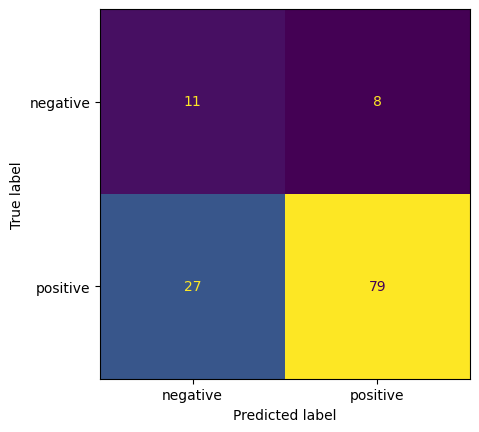

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nathanduran/general/f4de6a0fc25442feb384d2522a36f59c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [10]                : (0.5045750141143799, 0.9006749987602234)
COMET INFO:     batch_accuracy [320]         : (0.421875, 0.9112215638160706)
COMET INFO:     batch_loss [320]             : (0.23388151824474335, 0.7068315744400024)
COMET INFO:     epoch_duration [10]          : (41.54600000008941, 219.34400000004098)
COMET INFO:     loss [10]                    : (0.24950693547725677, 0.6938596963882446)
COMET INFO:     test_accuracy                : 0.7200000286102295
COMET INFO:     val_accuracy [10]            : (0.5019999742507935, 0.849399983882904)
COMET INFO:     val_loss [10]                : (0.339186429977417, 0.69258725

In [10]:
# Fit the model
results = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], validation_data=(X_val, y_val))
print("Validation Accuracy:", round(results.history["val_accuracy"][-1], 3))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Accuracy:', round(test_acc, 3))
experiment.log_metric("test_accuracy", test_acc)

# Predict class labels for test set
predictions = model.predict(X_test)
predictions = [0 if x < 0.5 else 1 for x in predictions] # Convert probabilities to binary

# Print/log confusion matrix
conf_matrix = ConfusionMatrixDisplay.from_predictions(y_test, predictions, display_labels=['negative', 'positive'], colorbar=False)
plt.show()
experiment.log_confusion_matrix(y_test, predictions, labels=['negative', 'positive'])

# End the experiment
experiment.end()

## 2.3 Exercise: Comet experiments and different parameters

So far we have only recorded a single experiment on Comet which uses the parameters we have already defined. Try exploring some configurations parameters to see if you can improve upon the accuracy achieved so far.

1. You should be able to provide access to a Comet project for all members of the group, so that everyone can log experiments. Individually you could each explore the impact of different experiment parameters and then use Comet to compare results e.g. one person explores sequence lengths, another model hyperparameters, optimisers and learning rates and so on.

2. Experiment with the panels and other visualisation options that are available on Comet to display your results.

## 2.4 Exercise: RNN architectures

As discussed in the lecture, there are several different architectural variations of RNN models, such as Bi-directional and stacked layers. Try experimenting with a few different architectures and evaluate the impact on classification accuracy.

1. A good first step might be to take output from *each* timestep (`return_sequences=True`), rather than the last only. You will need an additional pooling layer to perform dimensionality reduction on the RNN outputs so that they are compatible with the later classification layers.

2. Use the Keras [Bi-directional layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional) to convert the uni-directional LSTM into bi-directional.

3. Try stacking two LSTM layers. The first will need to output sequences, which become the inputs for the second layer. Then you can either take the last hidden state as output (as we did before), or pool the sequence of outputs, as in step 1.